In [1]:
import numpy as np
import nolearn
import sklearn.linear_model as lm
import scipy.stats as sps
import math
import pandas as pd

from decimal import Decimal
from lasagne import layers, nonlinearities
from lasagne.updates import nesterov_momentum
from lasagne import layers
from nolearn.lasagne import NeuralNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
from sklearn.externals import joblib

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using gpu device 0: Quadro 2000


In [2]:
import custom_funcs as cf
cf.init_seaborn('white', 'poster')
from isoelectric_point import isoelectric_points
from molecular_weight import molecular_weights

In [4]:
# Read in the protease inhibitor data
data, drug_cols, feat_cols = cf.read_data('hiv-protease-data.csv', n_data_cols=8)
print(len(data))
# Read in the consensus data
consensus_map = cf.read_consensus('hiv-protease-consensus.fasta')

# Clean the data
data = cf.clean_data(data, feat_cols, consensus_map)

# Identify feature columns
data = cf.drop_ambiguous_sequences(data, feat_cols)
data.dropna(inplace=True, subset=feat_cols)
data

1808


,FPV,ATV,IDV,LPV,NFV,SQV,TPV,DRV,P1,P2,...,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99
SeqID,,,,,,,,,,,,,,,,,,,,,
4432,1.5,NaN,1.0,NaN,2.2,1.1,NaN,NaN,P,Q,...,L,T,Q,I,G,C,T,L,N,F
4664,3.1,NaN,8.7,NaN,32.0,16.9,NaN,NaN,P,Q,...,M,T,Q,I,G,C,T,L,N,F
5221,NaN,NaN,0.8,0.8,1.2,0.7,NaN,NaN,P,Q,...,L,T,Q,I,G,C,T,L,N,F
5279,8.3,79.0,16.0,12.0,600.0,1000.0,NaN,NaN,P,Q,...,M,T,Q,I,G,C,T,L,N,F
5444,2.7,21.0,24.0,6.1,42.0,132.0,NaN,NaN,P,Q,...,M,T,Q,I,G,C,T,L,N,F
5462,2.1,16.0,12.0,22.0,15.0,82.0,NaN,NaN,P,Q,...,L,T,Q,I,G,C,T,L,N,F
5464,2.1,NaN,22.2,7.8,24.7,104.8,NaN,NaN,P,Q,...,M,T,Q,L,G,C,T,L,N,F
5681,NaN,NaN,26.0,25.0,37.0,7.4,NaN,NaN,P,Q,...,M,T,Q,L,G,C,T,L,N,F
6024,NaN,NaN,8.3,3.0,22.0,3.4,NaN,NaN,P,Q,...,M,T,Q,L,G,C,T,L,N,F


In [5]:
# consensus_map

In [52]:
print(drug_cols)

DRUG = 'IDV'

Index(['FPV', 'ATV', 'IDV', 'LPV', 'NFV', 'SQV', 'TPV', 'DRV'], dtype='object')


In [53]:
feat_cols

Index(['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21',
       'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31',
       'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40', 'P41',
       'P42', 'P43', 'P44', 'P45', 'P46', 'P47', 'P48', 'P49', 'P50', 'P51',
       'P52', 'P53', 'P54', 'P55', 'P56', 'P57', 'P58', 'P59', 'P60', 'P61',
       'P62', 'P63', 'P64', 'P65', 'P66', 'P67', 'P68', 'P69', 'P70', 'P71',
       'P72', 'P73', 'P74', 'P75', 'P76', 'P77', 'P78', 'P79', 'P80', 'P81',
       'P82', 'P83', 'P84', 'P85', 'P86', 'P87', 'P88', 'P89', 'P90', 'P91',
       'P92', 'P93', 'P94', 'P95', 'P96', 'P97', 'P98', 'P99'],
      dtype='object')

In [54]:
# Split data into predictor variables and dependent variables.
# Predictors are the sequence features
# Dependent are the drug resistance values
X, Y = cf.split_data_xy(data, feat_cols, DRUG)

# Binarize the sequence features such that there are 99 x 20 columns in total.
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(list('CHIMSVAGLPTRFYWDNEQK'))

X_binarized = pd.DataFrame()

for col in X.columns:
    binarized_cols = lb.transform(X[col])
    
    for i, c in enumerate(lb.classes_):
        X_binarized[col + '_' + c] = binarized_cols[:,i]
X_binarized

/home/ericmjl/hiv-resistance-prediction/custom_funcs.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if log_transform:


,P1_A,P1_C,P1_D,P1_E,P1_F,P1_G,P1_H,P1_I,P1_K,P1_L,...,P99_M,P99_N,P99_P,P99_Q,P99_R,P99_S,P99_T,P99_V,P99_W,P99_Y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


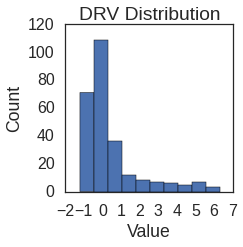

In [44]:
# View distribution of drug resistance values
import matplotlib.pyplot as plt
std = (3,3)
fig = cf.plot_Y_histogram(Y, DRUG, figsize=std)

/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


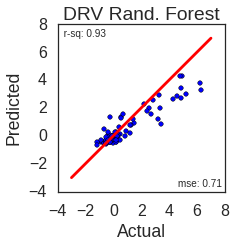

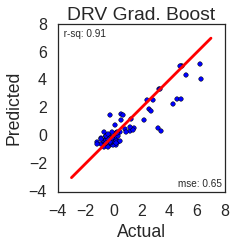

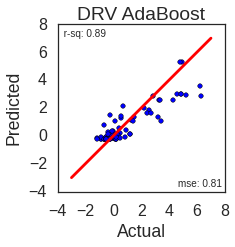

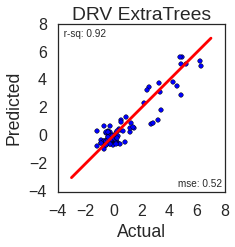

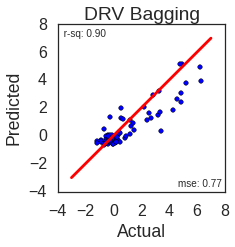

In [45]:
# Split data into training and testing set.
tts_data = X_train, X_test, Y_train, Y_test = train_test_split(X_binarized, Y, test_size=0.33)

# Train a bunch of ensemble regressors:
## Random Forest
kwargs = {'n_jobs':-1, 'n_estimators':1000}
rfr, rfr_preds, rfr_mse, rfr_r2 = cf.train_model(*tts_data, model=RandomForestRegressor, modelargs=kwargs)
## Gradient Boosting
kwargs = {'n_estimators':1000}
gbr, gbr_preds, gbr_mse, gbr_r2 = cf.train_model(*tts_data, model=GradientBoostingRegressor, modelargs=kwargs)
## AdaBoost
kwargs = {'n_estimators':1000}
abr, abr_preds, abr_mse, abr_r2 = cf.train_model(*tts_data, model=AdaBoostRegressor, modelargs=kwargs)
## ExtraTrees
kwargs = {'n_estimators':1000, 'n_jobs':-1}
etr, etr_preds, etr_mse, etr_r2 = cf.train_model(*tts_data, model=ExtraTreesRegressor, modelargs=kwargs)
## Bagging
bgr, bgr_preds, bgr_mse, bgr_r2 = cf.train_model(*tts_data, model=BaggingRegressor)

# Plot the results of regression
cf.scatterplot_results(rfr_preds, Y_test, rfr_mse, rfr_r2, DRUG, 'Rand. Forest', figsize=std)
plt.savefig('figures/{0} random_forest_poster.pdf'.format(DRUG), bbox_inches='tight')
cf.scatterplot_results(gbr_preds, Y_test, gbr_mse, gbr_r2, DRUG, 'Grad. Boost', figsize=std)
plt.savefig('figures/{0} gradient_boost_poster.pdf'.format(DRUG), bbox_inches='tight')
cf.scatterplot_results(abr_preds, Y_test, abr_mse, abr_r2, DRUG, 'AdaBoost', figsize=std)
plt.savefig('figures/{0} adaboost_poster.pdf'.format(DRUG), bbox_inches='tight')
cf.scatterplot_results(etr_preds, Y_test, etr_mse, etr_r2, DRUG, 'ExtraTrees', figsize=std)
plt.savefig('figures/{0} extratrees_poster.pdf'.format(DRUG), bbox_inches='tight')
cf.scatterplot_results(bgr_preds, Y_test, bgr_mse, bgr_r2, DRUG, 'Bagging', figsize=std)
plt.savefig('figures/{0} bagging_poster.pdf'.format(DRUG), bbox_inches='tight')

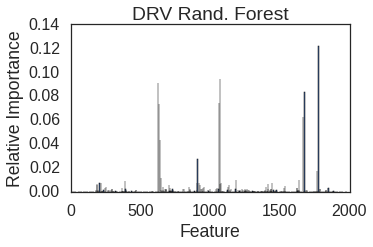

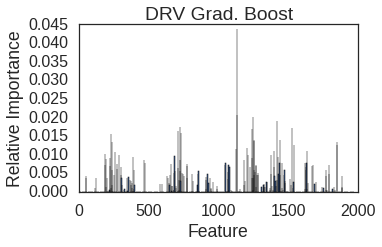

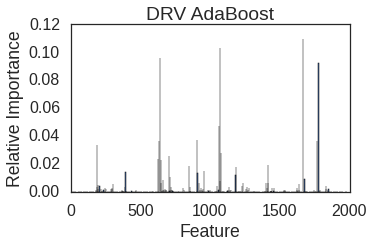

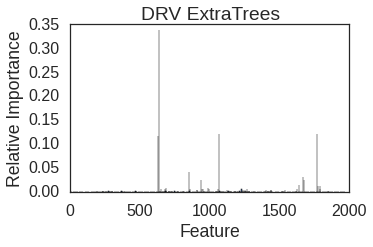

In [46]:
# Grab the feature importances - that is, how important a particular feature is for predicting drug resistance
cf.barplot_feature_importances(rfr, DRUG, 'Rand. Forest', figsize=(5,3))
plt.savefig('figures/{0} random_forest_feat_impt.pdf'.format(DRUG), bbox_inches='tight')
cf.barplot_feature_importances(gbr, DRUG, 'Grad. Boost', figsize=(5,3))
plt.savefig('figures/{0} gradient_boost_feat_impt.pdf'.format(DRUG), bbox_inches='tight')
cf.barplot_feature_importances(abr, DRUG, 'AdaBoost', figsize=(5,3))
plt.savefig('figures/{0} adaboost_feat_impt.pdf'.format(DRUG), bbox_inches='tight')
cf.barplot_feature_importances(etr, DRUG, 'ExtraTrees', figsize=(5,3))
plt.savefig('figures/{0} extratrees_feat_impt.pdf'.format(DRUG), bbox_inches='tight')
# cf.barplot_feature_importances(bgr, DRUG, 'Bagging') ## feature_importances_ do not exist for bagging

In [47]:
# Extract a table version of feature importance
rfr_fi = cf.extract_mutational_importance(rfr, X_test)
gbr_fi = cf.extract_mutational_importance(gbr, X_test)
abr_fi = cf.extract_mutational_importance(abr, X_test)

# Join data to compare random forest and gradient boosting.
# joined = rfr_fi.set_index(0).join(gbr_fi.set_index(0), lsuffix='r', rsuffix='g')
# sps.spearmanr(joined['1r'], joined['1g'])

rfr_fi

,0,1
0,P89_V,0.121577
1,P54_M,0.093829
2,P32_I,0.091195
3,P84_V,0.082912
4,P54_I,0.073816
5,P32_V,0.073189
6,P84_I,0.061994
7,P33_F,0.043106
8,P46_M,0.027262
9,P89_L,0.017128


/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


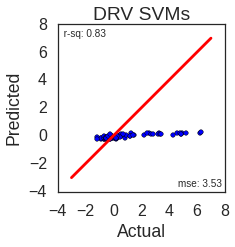

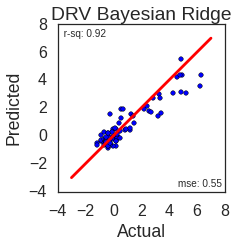

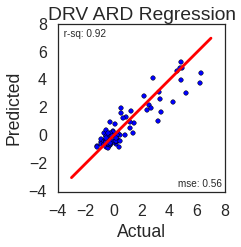

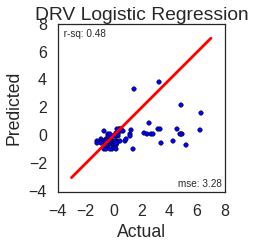

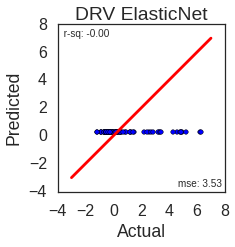

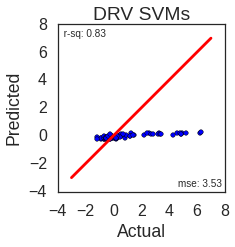

In [48]:
# Train a bunch of linear model learners for comparison.
brr, brr_preds, brr_mse, brr_r2 = cf.train_model(*tts_data, model=lm.BayesianRidge)
ard, ard_preds, ard_mse, ard_r2 = cf.train_model(*tts_data, model=lm.ARDRegression)
logr, logr_preds, logr_mse, logr_r2 = cf.train_model(*tts_data, model=lm.LogisticRegression)
enr, enr_preds, enr_mse, enr_r2 = cf.train_model(*tts_data, model=lm.ElasticNet)
svr, svr_preds, svr_mse, svr_r2 = cf.train_model(*tts_data, model=SVR)

# Likewise, plot the results
cf.scatterplot_results(brr_preds, Y_test, brr_mse, brr_r2, DRUG, 'Bayesian Ridge', figsize=std)
cf.scatterplot_results(ard_preds, Y_test, ard_mse, ard_r2, DRUG, 'ARD Regression', figsize=std)
cf.scatterplot_results(logr_preds, Y_test, logr_mse, logr_r2, DRUG, 'Logistic Regression', figsize=std)
cf.scatterplot_results(enr_preds, Y_test, enr_mse, enr_r2, DRUG, 'ElasticNet', figsize=std)
cf.scatterplot_results(svr_preds, Y_test, svr_mse, svr_r2, DRUG, 'SVMs', figsize=std)

In [49]:
# Let's now try a neural network. 
# Neural Network 1 Specification: Feed Forward ANN with 1 hidden layer.

x_train = X_train.astype(np.float32)
y_train = Y_train.astype(np.float32)
x_test = X_test.astype(np.float32)
y_test = Y_test.astype(np.float32)

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden1', layers.DenseLayer),
        ('dropout1', layers.DropoutLayer),
        #('hidden2', layers.DenseLayer),
        #('dropout2', layers.DropoutLayer),
        ('nonlinear', layers.NonlinearityLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, x_train.shape[1]),  # 
    hidden1_num_units=math.ceil(x_train.shape[1]),  # number of units in hidden layer
    hidden1_nonlinearity=nonlinearities.tanh,
    dropout1_p = 0.4,
    #hidden2_num_units=math.ceil(x_train.shape[1] / 2),
    #dropout2_p = 0.5,
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=1,  # 1 target values
    
    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.95,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=1000,  # we want to train this many epochs
    verbose=1,
    )
net1.fit(x_train.values, y_train.values)

# Neural Network with 3924361 learnable parameters

## Layer information

  #  name         size
---  ---------  ------
  0  input        1980
  1  hidden1      1980
  2  dropout1     1980
  3  nonlinear    1980
  4  output          1

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       2.80644      12.59575      0.22281  0.03s
      2      11.49591       1.44200      7.97221  0.03s
      3       1.20595       1.54199      0.78207  0.03s
      4       1.24281       1.46401      0.84891  0.03s
      5       1.16371       1.35799      0.85694  0.03s
      6       1.09715       1.27686      0.85926  0.03s
      7       1.02540       1.16649      0.87905  0.03s
      8       0.95007       1.07483      0.88392  0.03s
      9       0.77973       0.90449      0.86206  0.03s
     10       0.66705       0.76027      0.87739  0.03s
     11       0.62718       0.70209      0.89330  0.03s
     12       0.55892       0.55901   

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f835c13a8d0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f835c13a978>,
     custom_score=None, dropout1_p=0.4,
     hidden1_nonlinearity=<function tanh at 0x7f831345bbf8>,
     hidden1_num_units=1980, input_shape=(None, 1980),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('nonlinear', <class 'lasagne.layers.dense.NonlinearityLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=1000, more_params={},
     objective=<function objective at 0x7f8312e82158>,
     objective_loss_function=<function squared_error at 0x7f8312fc1488>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog object at 0x7f82d16a09b0>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasag

/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


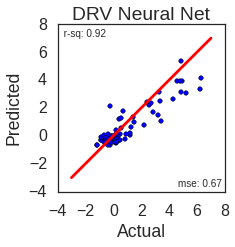

In [50]:
# And now let's also look at whether it looks good or not.
nn1_preds = net1.predict(x_test)
nn1_mse = float(mean_squared_error(nn1_preds, y_test))
nn1_r2 = float(sps.pearsonr(nn1_preds, y_test.reshape(y_test.shape[0],1))[0][0])

cf.scatterplot_results(nn1_preds, y_test, nn1_mse, nn1_r2, DRUG, 'Neural Net', figsize=std)
plt.savefig('figures/{0} neural_net_poster.pdf'.format(DRUG), bbox_inches='tight')

In [51]:
# Save the models to disk

joblib.dump(rfr, 'models/{0} random_forest.pkl'.format(DRUG))
joblib.dump(abr, 'models/{0} adaboost.pkl'.format(DRUG))
joblib.dump(etr, 'models/{0} extratrees.pkl'.format(DRUG))
joblib.dump(gbr, 'models/{0} gradient_boost.pkl'.format(DRUG))
joblib.dump(bgr, 'models/{0} bagging.pkl'.format(DRUG))
joblib.dump(net1, 'models/{0} neural_network.pkl'.format(DRUG))

['models/DRV neural_network.pkl',
 'models/DRV neural_network.pkl_01.npy',
 'models/DRV neural_network.pkl_02.npy',
 'models/DRV neural_network.pkl_03.npy',
 'models/DRV neural_network.pkl_04.npy',
 'models/DRV neural_network.pkl_05.npy',
 'models/DRV neural_network.pkl_06.npy',
 'models/DRV neural_network.pkl_07.npy']